In [27]:
# NOTE: Run this in Python 2.7
import requests
import urllib
import lxml
import imdb
from IPython.display import Image
import matplotlib.pyplot as plt

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes

import requests
import urllib
import imdb
import lxml.html
import numpy as np
import pandas as pd
import itertools
%matplotlib inline
import seaborn as sns
import math
import matplotlib.pyplot as plt

### Team MovieGnat

### Milestone 1: Getting to know your data, due Wednesday, April 5, 2017

In the beginning you should get acquainted with the data sources and do some EDA. Sign up for the TMDb [API](https://www.themoviedb.org/documentation/api), and try to download the poster of your favorite movie from within your notebook. Compare the genre entries of IMDb and TMDb for this movie and see if they are the same. Think about and write down some questions that you would like to answer in the following weeks. Keep the storytelling aspect of your final report in mind and do some pen and paper sketches about the visualizations you would like to produce. Include photographs of those sketches in your notebook. 

Most of the time a data scientist spends on a project is spend on cleaning the data. We are lucky that the data we have is already pretty clean. The Python interface to the IMDb ftp files does a lot of the additional work of cleaning as well. However, you will notice that the genre list for each movie from both databases can have different lengths. This needs to be changed in order to train a model to predict the movie genre. It is up to you to think about possible ways to address this problem and to implement one of them. There is no absolute right answer here. It depends on your interests and which questions you have in mind for the project. 

Optionally, you could also scrape additional data sources, such as Wikipedia, to obtain plot summaries. That data may give you additional useful features for genera classification. 

To guide your decision process, provide at least one visualization of how often genres are mentioned together in pairs. Your visualization should clearly show if a horror romance is more likely to occur in the data than a drama romance.

The notebook to submit for this milestone needs to at least include:

- API code to access the genre and movie poster path of your favorite movie
- Genre for this movie listed by TMDb and IMDb
- A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API
- Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them 
- Code to generate the movie genre pairs and a suitable visualization of the result
- Additional visualization sketches and EDA with a focus on movie genres
- A list of questions you could answer with this and related data. Get creative here!

The EDA questions do not necessarily have to tie into the modeling part later on. Think freely about things that might be interesting, like which actors are very specific to a genre? Are action movies more prone to producing sequels than romances? However, as you keep the focus on movie genres, think also about correlations you might discover that can help building features from the metadata for prediction. Is the length of a movie title correlated with genre?


## API code to access the genre and movie poster path of movie "Logan"


In [17]:
def requestResults(url):
    r = requests.get(BASE_URL + url + "&api_key=" + API_KEY)
    return r.json()

# Constants
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "9767d17413ec9d9729c2cca238df02da"
GENRE_MAP = {}
for g in requestResults("genre/movie/list?x=1")[u'genres']:
    GENRE_MAP[g['id']] = g['name']

# Download image
def downloadImageToFile(imgpath, filename):
    # Does not return anything
    urllib.urlretrieve("https://image.tmdb.org/t/p/w500" + imgpath, filename)
    
def movieDetails(title):
    title_query = urllib.urlencode({'query': title})
    result = requestResults("search/movie?" + title_query + "&language=en-US&page=1&include-adult=false")[u'results'][0]
    return result
    
# Get genre and poster path of one movie by title
def genreAndPosterPath(title):
    title_query = urllib.urlencode({'query': title})
    result = requestResults("search/movie?" + title_query + "&language=en-US&page=1&include-adult=false")[u'results'][0]
    genre_ids = result['genre_ids']
    genres = [str(GENRE_MAP[gid]) for gid in genre_ids]
    poster_path = result['poster_path']
    return genres, poster_path

# Get genres from IMDB for one movie by title
def imdbGenresByTitle(title):
    imdb_access = imdb.IMDb()
    id_ = imdb_access.search_movie(title)[0].__repr__().split('id:')[1].split('[')[0]
    hxs = lxml.html.document_fromstring(requests.get("http://www.imdb.com/title/tt" + id_).content)
    return hxs.xpath("//a[contains(@href, 'genre')]/text()")[1:]

# Get genres from TMDB for one movie by title
def tmdbGenresByTitle(title):
    title_query = urllib.urlencode({'query': title})
    genre_ids = requestResults("search/movie?" + title_query + "&language=en-US&page=1&include-adult=false")[u'results'][0]['genre_ids']
    return _mapGidsToGenres(genre_ids)

# Private helper function that maps genre_ids to genres
def _mapGidsToGenres(genre_ids):
    return [str(GENRE_MAP[gid]) for gid in genre_ids]

# EXAMPLES
# requestResults("discover/movie?sort_by=popularity.desc")[u'results'][0] # Get top 10 most popular results
# downloadImageToFile('/tnmL0g604PDRJwGJ5fsUSYKFo9.jpg', 't2s.jpg') # Download an image to the file t2s.jpg

## Genre for this movie listed by TMDb and IMDb

In [19]:
# Genre and movie poster path of your favorite movie from TMDB
fave_movie = 'Logan'

genres, poster_path = genreAndPosterPath(fave_movie)
print 'Fave movie: %s\n================\nGenres: %s\nPoster Path: %s' % (fave_movie, ', '.join(map(str, genres)), poster_path)

Fave movie: Logan
Genres: Action, Drama, Science Fiction
Poster Path: /45Y1G5FEgttPAwjTYic6czC9xCn.jpg


In [20]:
# Genre for this movie listed by TMDb and IMDb
imdb_genres_fave = imdbGenresByTitle(fave_movie)
tmdb_genres_fave = tmdbGenresByTitle(fave_movie)
print 'Genres of fave movie: %s\n================' % fave_movie
print 'IMDB: %s' % ', '.join(map(str, imdb_genres_fave))
print 'TMDB: %s' % ', '.join(map(str, tmdb_genres_fave))

# Challenge: Sci-Fi from IMDB is Science Fiction in TMDB! Need to find a genre mapping between both IMDB and TMDB.

Genres of fave movie: Logan
IMDB:  Action,  Drama,  Sci-Fi,  Thriller
TMDB: Action, Drama, Science Fiction


## A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API

In [38]:
# A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via TMDB

def top10movies_tmdb():
    results = requestResults("discover/movie?sort_by=popularity.desc")[u'results'][:10]
    return [{'title': str(r['title']), 'genres': _mapGidsToGenres(r['genre_ids'])} for r in results]

# Print top 10 movies
top10movies_dict = top10movies_tmdb()
print 'Top 10 movies and their genres: \n================'
for m in top10movies_dict:
    print '%s: %s' % (m['title'], ', '.join(map(str, m['genres'])))
    
    
    
def top_n_movies_tmdb(N):
    # only 20 results per page so need to send multiple request and increment page number 
    results_per_page = 20.0
    results = []
    num_pages = int(math.ceil(N/results_per_page))
    if num_pages == 1:
        results = requestResults("discover/movie?sort_by=popularity.desc")[u'results'][:N]
    else:
        for n in range(1, num_pages+1):
            result = requestResults("discover/movie?sort_by=popularity.desc&page={}".format(n))
            try:
                r= result[u'results']
                results = results + r
            except KeyError:
                pass

#     return [{'title': str(r['title'].encode('ascii', 'ignore').decode('ascii')), 'genres': _mapGidsToGenres(r['genre_ids'])} for r in results]
#     return [{'title': str(r['title'].encode('ascii', 'ignore').decode('ascii')), 'keywords': get_keywords(int(r[u'id'])), 'genres': _mapGidsToGenres(r['genre_ids'])} for r in results]
    return results
def get_keywords(movieid):
    results = requestResults("movie/{}/keywords?x=1".format(movieid))
    keywords = []
    try:
        k = results[u'keywords']
        keywords = [str(r[u'name'].encode('ascii', 'ignore').decode('ascii')) for r in k]
    except KeyError:
        pass
    return keywords    

Top 10 movies and their genres: 
Beauty and the Beast: Fantasy, Music, Romance
Logan: Action, Drama, Science Fiction
Sing: Animation, Comedy, Drama, Family, Music
Kong: Skull Island: Science Fiction, Action, Adventure, Fantasy
Ghost in the Shell: Action, Drama, Science Fiction
Jurassic World: Action, Adventure, Science Fiction, Thriller
Fantastic Beasts and Where to Find Them: Adventure, Action, Fantasy
The Boss Baby: Animation, Comedy, Family
Interstellar: Adventure, Drama, Science Fiction
Split: Horror, Thriller


## Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them

The data pulled contains skewed classes, especially relating to genre.  Certain classes are over-represented in the data set as shown in the head map below. Genres such as Action, Adventure and Sci-Fi are over represented, while War, Crime, and Music are underrepresented. 

One solution is to use stratified sampling to ensurethat the train, validation and test sets are well balanced. This will help ensure that the existing problem of skewed classes is not intensified. 

## Code to generate the movie genre pairs and a suitable visualization of the result 


In [34]:
# genre pair matching between IMDB/TMBD for top 1000 movies 

# Pairs of genres that co occur for movies from TMDB


num_genres = len(GENRE_MAP.keys())
genre_matrix = np.zeros((num_genres, num_genres))

genres = list(map(str, GENRE_MAP.values()))
genre_df = pd.DataFrame(genre_matrix)
genre_df.columns = genres
genre_df.index = genres



In [41]:
# retrieve top 1000 movies
top_1000_movies = top_n_movies_tmdb(1000)
top_1000_movie_genres = map(lambda m: map(str,m['genres']), top_1000_movies)

# # create all pairs of genres
genre_pairs = list(itertools.combinations(genres, 2))
for genre in genres:
    genre_pairs.append(genre)
    
# for each pair find # movies with that pair:
for pair in genre_pairs:
    for movie_genres in top_1000_movie_genres:
        if set(list(pair)).issubset(movie_genres):
            genre_df[pair[0]][pair[1]] += 1
    

KeyError: 'genre'

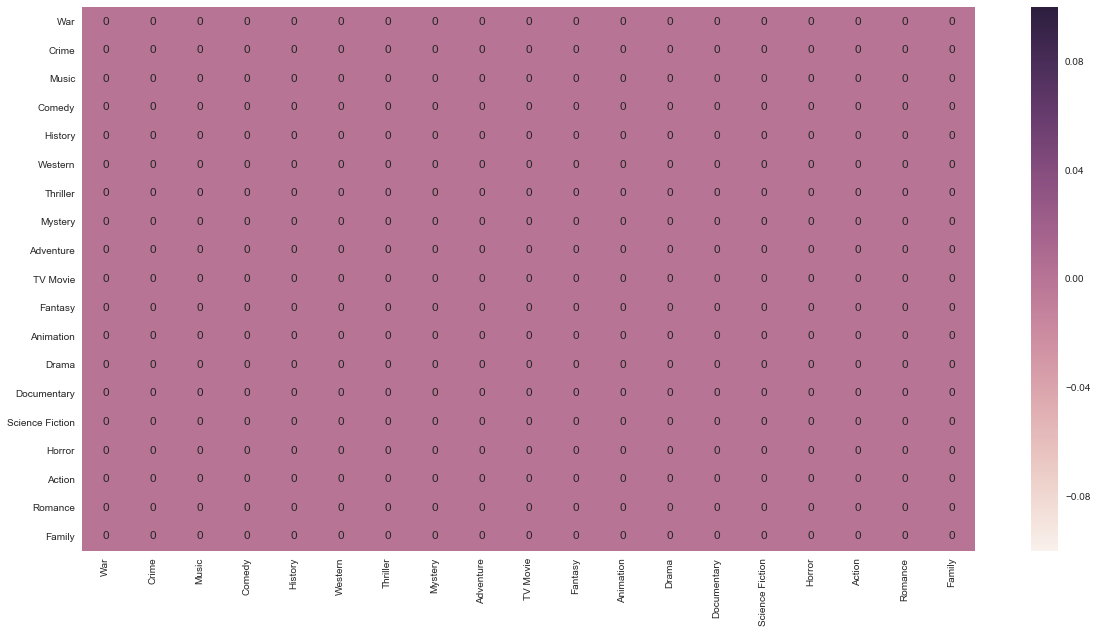

In [40]:
# plot heatmap of movie pairs that co-occur
plt.figure(figsize=(20,10))
sns.heatmap(genre_df, annot=True,fmt="g")

## Additional visualization sketches and EDA with a focus on movie genres

In [ ]:
# genre bar chart counts for top 1000 movies
all_genres = list(itertools.chain.from_iterable(top_1000_movie_genres))
genres_unique, all_genres_counts = np.unique(all_genres, return_counts=True)
sorted_counts = [g for (g, c) in sorted(zip(all_genres_counts, genres_unique))]
sorted_genres = [c for (g, c) in sorted(zip(all_genres_counts, genres_unique))]

fig, ax = plt.subplots(figsize=(20, 10))
num_unique_genres = len(all_genres_counts)
ax.bar(range(num_unique_genres), sorted_counts)
ax.set_xticks(np.arange(num_unique_genres)+0.3)
ax.set_xticklabels(sorted_genres, rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [31]:
# keywords by genre
genre_keywords = {}
for genre in genres:
    genre_keywords[genre] = {}

for movie in top_1000_movies:
    for genre in movie['genres']:
        for word in movie['keywords']:
            if not word in genre_keywords[genre]:
                genre_keywords[genre][word] = 1
            else:
                genre_keywords[genre][word] += 1
#         genre_keywords[genre] = genre_keywords[genre].union(movie['keywords'])    

KeyError: 'genres'

In [ ]:
sorted_genre_counts = {}
for genre in genres:
    sorted_genre_counts[genre] = sorted([(value,key) for (key,value) in genre_keywords[genre].items()], reverse=True)

In [ ]:
for genre in genres:
    print genre + ' : ' + str([l for l in sorted_genre_counts[genre][:5]])

In [ ]:
# top 200 movies popularity, average vote count, vote_average

popularity_top200 = []
vote_average_top200 = []
vote_count_top200 = []

top200_movies = []
top200_movies = top_n_movies_tmdb(200)


for movie in top200_movies:
    popularity_top200.append(movie['popularity'])
    vote_average_top200.append(movie['vote_average'])
    vote_count_top200.append(movie['vote_count'])
    
# plot histograms of popularity, vote average and vote count for top 200 movies
fig, axs = plt.subplots(1,3)
fig.set_size_inches(20, 5)
sns.distplot(popularity_top200, kde=False, rug=True, ax=axs[0])
axs[0].set_xlabel('Popularity for top 200 movies')
axs[0].set_ylabel('Number of movies')
sns.distplot(vote_average_top200, kde=False, rug=True, ax=axs[1])
axs[1].set_xlabel('Vote Average for top 200 movies')
axs[1].set_ylabel('Number of movies')
sns.distplot(vote_count_top200, kde=False, rug=True, ax=axs[2])
axs[2].set_xlabel('Vote count for top 200 movies')
axs[2].set_ylabel('Number of movies')

In [ ]:
# Word cloud of keywords of top movies from year to year
def getKeywordsByYear(year):
    top_movies = requestResults("discover/movie?sort_by=popularity.desc&year=" + str(year))[u'results']
    top_ids = [m[u'id'] for m in top_movies]
    keywords = []
    for movie_id in top_ids:
        keywords += _getKeywordsById(movie_id)
    return keywords

# Private helper function that gets keywords by movie id
def _getKeywordsById(movie_id):
    keywords_dict = requestResults("movie/" + str(movie_id) + "/keywords?language=en-US")[u'keywords']
    return [str(k[u'name']) for k in keywords_dict]

keywords_1995 = getKeywordsByYear(1995)
keywords_2000 = getKeywordsByYear(2000)
keywords_2005 = getKeywordsByYear(2005)
keywords_2010 = getKeywordsByYear(2010)
keywords_2015 = getKeywordsByYear(2015)


In [ ]:
# Using https://www.jasondavies.com/wordcloud/, we plotted word clouds of the keywords of top movies in each year

# Keywords in 1995
Image("keywords_1995.png")

We see detective, drugs and dystopia being key themes in 1995 movies. Sounds like a distrust for police during that time due to riots and mafia?

In [ ]:
# Keywords in 2000
Image("keywords_2000.png")

In 2000, we see similar themes compared to 1995. We still see dystopia and violence being big themes, and the strength of mafias. We start seeing some positive elements creep in with pixar and friendship!

In [ ]:
# Keywords in 2005
Image("keywords_2005.png")

In 2005, dystopia is still key, but it is getting increasingly positive. We start seeing pixar, friendship, hero and saving the world becoming key themes. We're getting more optimistic about our world :)

In [ ]:
# Keywords in 2010
Image("keywords_2010.png")

In 2010, we finally get rid of too much dystopia and the key focus is on technology's invasion of the world. We have artificial intelligence, killer robots, fantasy world, cyborgs, etc. 3D movies also starts creeping in.

In [ ]:
# Keywords in 2015
Image("keywords_2015.png")

2015 is quite similar to 2010 in terms of the increase in technology themes such as spaceship. 3D has become a central theme now and applies to many movies. Dystopia has also emerged again, and the themes of the movies this year seem pessimistic again.

In [ ]:
genreCountsByYears = [] # Initialize it here first

In [ ]:
def genreCountByYear(year):
    genre_count = {}
    for p in range(1,26): # Top 500 movies
        results_p = requestResults("discover/movie?sort_by=popularity.desc&page=" + str(p) + "&year=" + str(year))[u'results']
        for m in results_p:
            for g in m[u'genre_ids']:
                # Map g to genre name
                if g not in GENRE_MAP:
                    continue
                g_name = str(GENRE_MAP[g])
                if g_name not in genre_count:
                    genre_count[g_name] = 1
                else:
                    genre_count[g_name] = genre_count[g_name] + 1
    return genre_count

# Compute genre counts of each year from 1995 to 2016
# Run them one by one as they are async

genreCountsByYears.append(genreCountByYear(2016))

In [ ]:
# Compare horror and comedy across the years
horror_counts = [gy['Horror'] for gy in genreCountsByYears]
comedy_counts = [gy['Comedy'] for gy in genreCountsByYears]

plt.title('Horror vs Comedy')
plt.plot(horror_counts, label='Horror')
plt.plot(comedy_counts, label='Comedy')
plt.legend(loc='best')
plt.show()
plt.grid()

It's interesting how as horror increases in popularity through the years, comedy seems to decrease in popularity.

In [ ]:
# Figure out top and bottom genres across the years

top_genres = [max(gy, key=lambda k: gy[k]) for gy in genreCountsByYears]
top_genres
print 'Top genre every year is: Drama'

bottom_genres = [min(gy, key=lambda k: gy[k]) for gy in genreCountsByYears]
bottom_genres
print 'Bottom genres toggle between: TV Movie, Western, Documentary'

In [ ]:
# Plot the growth of a few genres
plt.figure(figsize=(25,12))
action_counts = [gy['Action'] for gy in genreCountsByYears]
adventure_counts = [gy['Adventure'] for gy in genreCountsByYears]
animation_counts = [gy['Animation'] for gy in genreCountsByYears]
romance_counts = [gy['Romance'] for gy in genreCountsByYears]
war_counts = [gy['War'] for gy in genreCountsByYears]
plt.title('Action, Adventure, Animation, Romance, War')
plt.plot(action_counts, label='Action')
plt.plot(adventure_counts, label='Adventure')
plt.plot(animation_counts, label='Animation')
plt.plot(romance_counts, label='Romance')
plt.plot(war_counts, label='War')
plt.legend(loc='best')
plt.show()


## A list of questions you could answer with this and related data

Potential questions to answer include classical, supervised, statistic analysis such as the relationship between: 

- genres and popularity
- genre and votes 
- release date (season) and popularity
- genre and runtime 
- ...and many more combinations exploring the relationship between different variables. 

For the purposes of this course, we are interested in implimenting unsupervised learning models on the data. 

The group discussed the following ideas: 

- performing PCA analysis to determine the most important predictors of a successful movie.
- using keywords or plot summaries to develop short captions posters. 
- using keywords plot summaries to develop 1-line captions or summaries of the plot. 
- using Convolutional Neural Networks to classify poster images and develop captions.
- using Convolutional Neural Networks to classify poster images, and develop captions based on genre. 

In [ ]:
# STANDALONE TO GRAB ALL MOVIES AND KEYWORDS

import csv
import time
import requests


#########################################################
'''
BASE STUFF THAT IS ALSO DEFINED ON TOP
'''
def requestResults(url):
    r = requests.get(BASE_URL + url + "&api_key=" + API_KEY)
    return r.json()

# Constants
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "9767d17413ec9d9729c2cca238df02da"
GENRE_MAP = {}
for g in requestResults("genre/movie/list?x=1")[u'genres']:
    GENRE_MAP[g['id']] = g['name']
    
#########################################################

def _getKeywordsStringById(movie_id):
    
    keywords_dict = requestResults("movie/" + str(movie_id) + "/keywords?language=en-US")
    if u'keywords' not in keywords_dict:
        return ''
    keywords_dict = keywords_dict[u'keywords']
    kstring = ''
    for k in keywords_dict:
        kstring += k[u'name'] + ','
    return str(kstring.encode('utf-8').strip())[:-1]

def _tidyRow(m, keywords):
    # Makes sure the row of movie is well-formatted
    output = {}
    for k in m:
        typem = type(m[k])
        k = str(k)
        if typem == str or typem == unicode:
            output[k] = m[k].encode('utf-8').strip()
        else:
            output[k] = m[k]
    output['keywords'] = keywords
    return output

def downloadMoviesToCSV(start_page, increment, filename):
    genre_count = {}
    
    with open(filename, 'w') as csvfile:
        fieldnames = ['id', 'genre_ids', 'poster_path', 'title', 'overview', 'release_date', 
                      'popularity', 'original_title', 'backdrop_path', 'keywords', 
                     'vote_count', 'video', 'adult', 'vote_average', 'original_language']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Get keywords for movies
        writer.writeheader()
        
        # TMDB limits 4 requests per second
        hit = 3 # Once hit reaches 0, call timer and reset hit to 3
        
        for p in range(start_page,start_page+increment): 
            if p%10 == 0:
                print('page: ', p)
            results_p = requestResults("discover/movie?sort_by=popularity.desc&page=" + str(p))[u'results']
            hit -= 1
            if hit <= 0:
                hit = 3
                time.sleep(1)

            # Write to CSV
            
            for m in results_p:
                mid = m[u'id']
                keywords = _getKeywordsStringById(mid)
                hit -= 1
                if hit <= 0:
                    hit = 3
                    time.sleep(1)
                
                row = _tidyRow(m, keywords)
                writer.writerow(row)

#             time.sleep(0.5) # We hit 2 requests per second without the keywords

In [ ]:
downloadMoviesToCSV(start_page=601, increment=200, filename='tmdb-movies_601.csv')

('page: ', 610)
('page: ', 620)
('page: ', 630)
('page: ', 640)
('page: ', 650)
('page: ', 660)
('page: ', 670)
